Analyses of the overall extent of MSY gene expression in human tissues

In [23]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import msyexp.datasets as ds
import msyexp.general as general
import msyexp.plotfuncs as pf
import msyexp.xytools as xytools

In [2]:
outdir = '{}/msy_overview'.format(ds.paths.NBOUTDIR)
if not os.path.exists(outdir):
    os.mkdir(outdir)

### Clustermap of MSY gene expression

#### Load Data

In [3]:
data = ds.get_gtex_data(males_only=True, adjusted=True)
meta = ds.get_metadata()
meta_ = meta.set_index('SAMPID')

#### Save median TPMs per tissue

In [4]:
# sample-level TPMs for MSY genes
ydata = data.loc[xytools.MSYFAMS].copy()

# median TPMs by tissue
ybt = general.stat_by_tissue(ydata, meta)
ybt.to_csv("{}/msy_genes_median_tpm_by_tissue.txt".format(outdir), sep='\t')

In [5]:
ybt.head()

,Adipose - Subcutaneous,Adipose - Visceral,Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Brain - Amygdala,Brain - Cerebellum,Brain - Cortex,Brain - Hippocampus,...,Prostate,Salivary Gland,Skeletal Muscle,Skin,Small Intestine,Spinal Cord,Spleen,Stomach,Testis,Thyroid
AMELY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.021345,0.084803,0.000000,0.000000,0.000000,0.000000,0.000000,0.080408,0.398626,1.046855
BPY2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.162268,0.000000,0.000000,0.000000,0.000000,9.277914,0.000000
CDY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.987732,0.000000
DAZ,0.020124,0.015370,0.013454,0.016774,0.019974,0.000000,0.023111,0.000000,0.023713,0.022313,...,0.043724,0.032726,0.000000,1.679619,0.011816,0.049478,0.014679,83.074321,29.515823,0.000000
DDX3Y,32.598993,41.118749,38.202901,45.394946,40.515079,52.294605,19.004839,52.177082,23.611759,17.559596,...,28.139995,21.158663,22.120235,23.115894,10.058318,16.768380,30.896850,14.896095,85.802904,32.807151


#### How many MSY genes are expressed in at least one tissue?

Criteria:
* \>1 TPM in median sample
* \>0.5 TPM in 90% of samples

In [6]:
# expression level at 10th percentile
y_p10th = ydata.groupby(by=lambda s: meta_.at[s, 'TISSUE'], axis=1).quantile(0.1)

# meet both criteria
is_expressed = ((ybt > 1) & (y_p10th > 0.5)).any(axis=1)
print("number of MSY genes expressed in at least one tissue = {}".format(is_expressed.sum()))
is_expressed

number of MSY genes expressed in at least one tissue = 24


AMELY      False
BPY2        True
CDY         True
DAZ         True
DDX3Y       True
EIF1AY      True
HSFY        True
KDM5D       True
NLGN4Y      True
PCDH11Y     True
PRKY        True
PRY         True
RBMY        True
RPS4Y1      True
RPS4Y2      True
SRY         True
TBL1Y       True
TGIF2LY     True
TMSB4Y      True
TSPY        True
TXLNGY      True
USP9Y       True
UTY         True
VCY         True
XKRY       False
ZFY         True
dtype: bool

#### Plot Clustermap

Ordering by hierarchical clustering: average-linkage using correlation distance.

Note that no cross-sample/tissue normalization has been applied to these expression levels, so, to some extent, the tissue where each gene shows highest expression reflects tissue-to-tissue differences in the transcriptome-wide gene expression distribution.

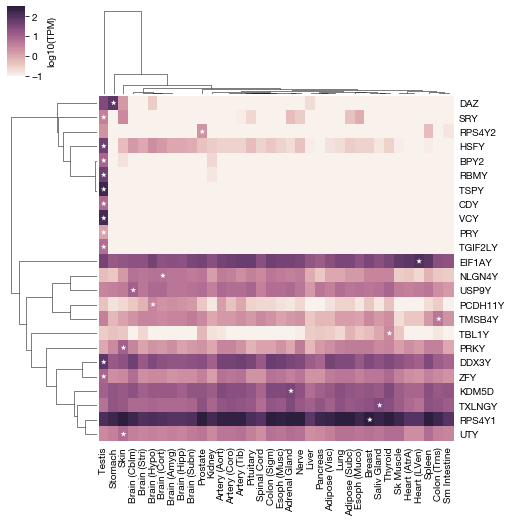

In [7]:
# plot parameters
vmax_log = 2.5  # trim log10(TPM) values beyond this value
vmin = 0.1      # trim TPM values lower than this value
method = 'average'       # linkage algorithm
metric = 'correlation'  # distance metric

# filter out genes that are not expressed
ybt1 = ybt.loc[is_expressed].copy()
ybt1[ybt1 < vmin] = vmin

cticks = [-1, 0, 1, 2]

clustmap = sns.clustermap(np.log10(ybt1), method=method, metric=metric,
                          cmap=pf.COLPAL_SEQ, vmax=vmax_log, 
                          cbar_kws={'ticks':cticks, 'label':'log10(TPM)'})
for lab in clustmap.ax_heatmap.get_yticklabels():
    lab.set_style('italic')

# mark the tissue where each gene has highest expression level
df = clustmap.data2d.copy() # reordered dataframe
tmax = df.idxmax(axis=1)
t_order = list(df.columns)
tmax_idx = list(map(lambda t: t_order.index(t), tmax))
ys = np.arange(df.shape[0]) + 0.5
xs = np.array(tmax_idx) + 0.5
clustmap.ax_heatmap.scatter(xs, ys, edgecolors='none', 
                            facecolors='w', marker='*')

# plot formatting
ax = pf.simplify_tissues(clustmap.ax_heatmap, axis='x')
clustmap.fig.set_figheight(8)
clustmap.fig.set_figwidth(8)
clustmap.ax_heatmap.tick_params(right=False, bottom=False, pad=2)
clustmap.ax_heatmap.set_ylim([24, 0])

clustmap.fig.savefig("{}/msy_clustermap.avg_correlation.tpm_norm.pdf".format(outdir))

### Plot big grid of expression for all MSY genes

AMELY... [1/26]
BPY2... [2/26]
CDY... [3/26]
DAZ... [4/26]
DDX3Y... [5/26]
EIF1AY... [6/26]
HSFY... [7/26]
KDM5D... [8/26]
NLGN4Y... [9/26]
PCDH11Y... [10/26]
PRKY... [11/26]
PRY... [12/26]
RBMY... [13/26]
RPS4Y1... [14/26]
RPS4Y2... [15/26]
SRY... [16/26]
TBL1Y... [17/26]
TGIF2LY... [18/26]
TMSB4Y... [19/26]
TSPY... [20/26]
TXLNGY... [21/26]
USP9Y... [22/26]
UTY... [23/26]
VCY... [24/26]
XKRY... [25/26]
ZFY... [26/26]


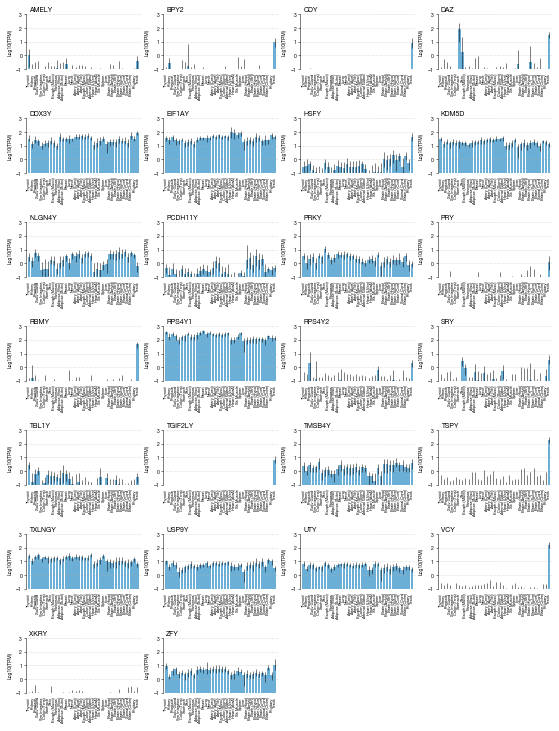

In [8]:
ncol = 4
nrow = 7

fig_w = 8.5
fig_h = 11.

# axes width in inches
ax_w_in = 1.59
ax_h_in = 0.76
# ...relative width
ax_w = ax_w_in / fig_w
ax_h = ax_h_in / fig_h

# margins
marg_l = 0.694 / fig_w
marg_r = 0.5 / fig_w
marg_t = 0.644 / fig_h
marg_b = 0.935 / fig_h

# padding
pad_w = (1 - (marg_l + marg_r) - (ncol * ax_w)) / (ncol - 1)
pad_h = (1 - (marg_t + marg_b) - (nrow * ax_h)) / (nrow - 1)

fig = plt.figure(figsize=(fig_w, fig_h))
axes = []
bottom0 = 1 - marg_t - ax_h
ct = 0
for i in range(nrow):
    bottom = bottom0 - i * (ax_h + pad_h)
    for j in range(ncol):
        left = marg_l + j * (ax_w + pad_w)
        axes.append(fig.add_axes([left, bottom, ax_w, ax_h]))
        ct += 1
        if ct == len(xytools.MSYFAMS):
            break
    if ct == len(xytools.MSYFAMS):
        break

ydata = data.loc[xytools.MSYFAMS]
ydata.index.name = 'gene'
df = pd.melt(ydata.reset_index(), id_vars='gene', var_name='SAMPID', value_name='TPM')
df = pd.merge(df, meta[['SAMPID', 'TISSUE']], on='SAMPID')
df.loc[df['TPM'] < 0.1, 'TPM'] = 0.1
df['Log10(TPM)'] = np.log10(df['TPM'])

tissues = meta_.loc[data.columns, 'TISSUE'].unique()
tissues = list(filter(lambda g: g in tissues, pf.TISSUE_ORDER))

for i, (g, ax) in enumerate(zip(xytools.MSYFAMS, axes)):
    general._print("{0}... [{1}/{2}]".format(g, i+1, len(xytools.MSYFAMS)))
    
    xs = np.arange(len(tissues))
    groups = df.loc[df.gene==g, ['TISSUE', 'Log10(TPM)']].groupby('TISSUE')
    y_med = groups.median()['Log10(TPM)'].reindex(tissues)
    y_lo = y_med - groups.quantile(0.025)['Log10(TPM)'].reindex(tissues)
    y_hi = groups.quantile(0.975)['Log10(TPM)'].reindex(tissues) - y_med
    
    ax.bar(xs, y_med+1, bottom=-1, edgecolor='none', facecolor='#6baed6',
           yerr=[y_lo, y_hi], tick_label=tissues, ecolor='k',
           error_kw={'lw':0.5})

    ax.set_ylim(-1, 3)
    ax.set_yticks([-1, 0, 1, 2, 3])
    ax.set_ylabel("Log10(TPM)")

    ax.set_xlabel('')
    ax.grid(axis='y', ls=':', lw=0.5, color='0.7')
    ax = pf.rotate_ticklabels(ax, 'x')
    ax = pf.simplify_tissues(ax, 'x')
    ax = pf.format_spines(ax, bottom=False)
    ax = pf.format_axis_labels(ax, xtlabsize=4, ytlabsize=5, labsize=5)
    
    ax.set_xlim(-1, 36)
    ax.text(0, 3.2, g, size=7, style='italic', weight='bold')
    
fig.savefig("{}/big_MSY_grid.pdf".format(outdir))

### DAZ/DAZL expression

Load data from males and females

In [9]:
data = ds.get_gtex_data(males_only=False, adjusted=True)

Normalize across samples

In [10]:
data_h = general.housekeeping_normalize(data)

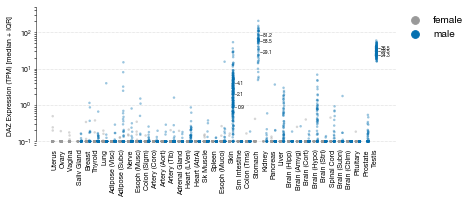

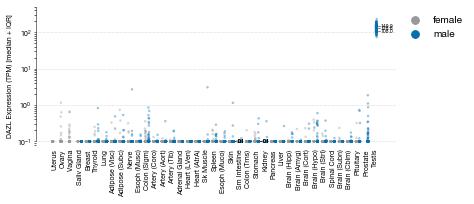

In [11]:
for gene in ['DAZ', 'DAZL']:
    fig, ax = pf.plot_male_female_stripplot(data, meta, gene)
    ax.set_ylim(0.08, 500)
    ax.spines['left'].set_bounds(0.1, 500)

    # annotate 25th, 75th percentiles and median
    lab = '{}_TPM'.format(gene)
    df = pd.DataFrame({lab:data.loc[gene]})
    df[df < 0.1] = 0.1
    df = pd.merge(df, meta[['SAMPID', 'SEX', 'TISSUE']], left_index=True, 
                  right_on='SAMPID')
    df = df.loc[df.SEX=='male'].copy()

    tissues = ['Skin', 'Stomach', 'Testis']
    for t in tissues:
        # get x-coord of tissue
        xt = list(map(lambda l: l.get_text(), ax.get_xticklabels())).index(t)
        # y-coords for 25th, 50th, and 75th percentiles
        yts = np.percentile(df.loc[df.TISSUE==t, lab], (25, 50, 75))
        for y in yts:
            ax.plot([xt+0.4, xt+0.6], [y, y], ls='-', color='k', lw=0.5)
            ax.text(xt+0.7, y, "{:.1f}".format(y), horizontalalignment='left',
                    verticalalignment='center', size=5)
    ax.set_ylabel("{} Expression (TPM) [median + IQR]".format(gene))

    fig.savefig("{0}/{1}_expression.pdf".format(outdir, gene))

### Contribution of MSY expression to X–Y gene pair expression breadth

Load male and female data

In [12]:
data = ds.get_gtex_data(males_only=False, adjusted=True)
mdata, fdata = general.split_male_female_samples(data, meta)

Extract expression levels for X and Y homologs in XX and XY samples

In [13]:
xgenes = [g for g in xytools.XYPAIRS_X]
ygenes = [g for g in xytools.XYPAIRS_Y]
idx = ['{0}/{1}'.format(x, y) for (x, y) in zip(xgenes, ygenes)]

df_xx = general.stat_by_tissue(fdata.loc[xgenes], meta)
df_x = general.stat_by_tissue(mdata.loc[xgenes], meta)
df_y = general.stat_by_tissue(mdata.loc[ygenes], meta)

# rename index
df_xx.index = df_x.index = df_y.index = idx

# filter unexpressed
okgenes = df_xx.gt(1).any(axis=1) | (df_x+df_y).gt(1).any(axis=1)

# reindex
df_xx = df_xx.loc[okgenes]
df_x = df_x.loc[okgenes]
df_y = df_y.loc[okgenes]

# subset to tissues found in both sexes + male-specific tissue,
# putting male-specific tissues at the end of the list
tissues = [t for t in pf.TISSUE_ORDER]
tissues = list(filter(lambda t: not t in ('Prostate', 'Testis', 'Kidney'), tissues))
tissues = list(filter(lambda t: t in df_xx.columns, tissues))
tissues = tissues + ['Prostate', 'Testis']

df_xx = df_xx.reindex(tissues, axis=1)
df_x = df_x.reindex(tissues, axis=1)
df_y = df_y.reindex(tissues, axis=1)
df_xy = df_x + df_y

df_xx.index.name = 'pair'
df_x.index.name = 'pair'
df_y.index.name = 'pair'
df_xy.index.name = 'pair'

print(df_xx.shape == df_x.shape == df_y.shape)

True


Save summary data---expression of X homologs of MSY genes in XX and XY individuals

In [14]:
# X homologs in XY individuals
_df = df_x.copy()
_df.index = list(map(lambda g: g.split('/')[0], _df.index))
_df.to_csv("{}/x_homologs_median_tpm_by_tissue.XY_indivs.txt".format(outdir), sep='\t')

# X homologs in XX individuals
_df = df_xx.copy()
_df.index = list(map(lambda g: g.split('/')[0], _df.index))
_df.to_csv("{}/x_homologs_median_tpm_by_tissue.XX_indivs.txt".format(outdir), sep='\t')

We are looking for instances where the expression of an MSY gene causes the corresponding X–Y gene pair to be expressed only in a tissue found in XY individuals, but not in XX individuals. Thus, we are looking for cases where...
* an X–Y pair/tissue combination where the X–Y pair is >3 TPM in (XY) males and <1 TPM in (XY) females
* among the examples from above, we are further looking for the cases where the expression in males is due almost exclusively to the Y chromosome

In [15]:
# combine XX, X, Y, and X+Y values into single dataframe
d1 = pd.melt(df_xx.reset_index(), id_vars='pair', value_name='XXf_TPM', var_name='tissue')
d2 = pd.melt(df_x.reset_index(), id_vars='pair', value_name='Xm_TPM', var_name='tissue')
d3 = pd.melt(df_y.reset_index(), id_vars='pair', value_name='Ym_TPM', var_name='tissue')
d4 = pd.melt(df_xy.reset_index(), id_vars='pair', value_name='XYm_TPM', var_name='tissue')

df = pd.merge(d1, d2, on=['pair', 'tissue'])
df = pd.merge(df, d3, on=['pair', 'tissue'])
df = pd.merge(df, d4, on=['pair', 'tissue'])

# calculate fraction of expression in XY samples due to Y gene
df['frac_Ym/XYm'] = df['Ym_TPM'] / df['XYm_TPM']

df.head(10)

,pair,tissue,XXf_TPM,Xm_TPM,Ym_TPM,XYm_TPM,frac_Ym/XYm
0,DDX3X/DDX3Y,Thyroid,100.092471,76.616729,33.342307,109.959036,0.303225
1,EIF1AX/EIF1AY,Thyroid,51.455772,39.267555,27.335959,66.603514,0.410428
2,HSFX/HSFY,Thyroid,2.019206,1.991327,0.285294,2.276620,0.125314
3,KDM5C/KDM5D,Thyroid,37.706014,26.079399,29.373158,55.452558,0.529699
4,NLGN4X/NLGN4Y,Thyroid,1.148233,1.029534,2.982575,4.012108,0.743393
5,PCDH11X/PCDH11Y,Thyroid,0.109052,0.129544,0.438219,0.567763,0.771835
6,PRKX/PRKY,Thyroid,41.799518,28.598127,3.183882,31.782009,0.100179
7,RBMX/RBMY,Thyroid,137.698856,147.701726,0.000000,147.701726,0.000000
8,RPS4X/RPS4Y1,Thyroid,1146.465340,835.420692,281.629413,1117.050106,0.252119
9,SOX3/SRY,Thyroid,0.091570,0.101376,0.000000,0.101376,0.000000


Identify cases where gene is expressed in XY but not XX; sort by proportion of expression due to Y.

In [16]:
df.loc[(df['XXf_TPM'] < 1) & (df['XYm_TPM'] > 3)].sort_values('frac_Ym/XYm', ascending=False)

,pair,tissue,XXf_TPM,Xm_TPM,Ym_TPM,XYm_TPM,frac_Ym/XYm
104,SOX3/SRY,Skin,0.000000,0.000000,3.151274,3.151274,1.000000
346,NLGN4X/NLGN4Y,Adrenal Gland,0.205655,0.152950,3.520812,3.673761,0.958367
23,NLGN4X/NLGN4Y,Salivary Gland,0.389559,0.246630,2.840795,3.087425,0.920118
612,NLGN4X/NLGN4Y,Pituitary,0.704248,0.575725,4.289457,4.865182,0.881664
270,NLGN4X/NLGN4Y,Artery - Aorta,0.885852,0.863735,5.068153,5.931888,0.854391
289,NLGN4X/NLGN4Y,Artery - Tibial,0.570566,0.766754,2.370286,3.137039,0.755581


#### Plot XX vs. XY expression for *NLGN4X/Y* and *SOX3/SRY*

In [17]:
def plot_expression_in_xx_vs_xy(df, pair):
    """ horizontal bar plot comparing expression of pair in XX and XY tissues 
    
    df : DataFrame
        long-form dataframe with columsn for X-Y pair (`pair`), `tissue`, 
        expression of pair in XX (`XXf_TPM`) and XY (`XYm_TPM`), and 
        the fraction of expression in XY due to the Y (`frac_Ym/XYm`)
    pair : str
        name of the X-Y pair
    """
    _df = df.loc[df['pair']==pair].copy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.5, 4.5))
    fig.subplots_adjust(wspace=0.6, left=0.05, right=0.95, top=0.9)

    def _format_spine(ax, side):
        ax.spines[side].set_color('k')
        ax.spines[side].set_linewidth(0.5)

    # determine tissue order, placing tisseus where >1TPM at top of list
    _df = _df.sort_values('frac_Ym/XYm', ascending=False)
    exp_rows = (_df['XXf_TPM'] > 1) | (_df['XYm_TPM'] > 1)
    t_order = list(_df.loc[exp_rows, 'tissue']) + list(_df.loc[~exp_rows, 'tissue'])
    t_lo = list(_df.loc[~exp_rows, 'tissue'])
    t_lo_abbr = list(map(lambda t: pf.TISSUE_ABBR[t], t_lo))

    # XX females
    ax1 = sns.barplot(x='XXf_TPM', y='tissue', data=_df,
                      ax=ax1, order=t_order, color='0.7')
    ax1.set_yticklabels([])
    ax1.spines['left'].set_visible(False)

    # XY males
    ax2 = sns.barplot(x='XYm_TPM', y='tissue', data=_df,
                      ax=ax2, order=t_order, color=pf.COLOR_BLUE,
                      label=pair.split('/')[1])
    ax2 = sns.barplot(x='Xm_TPM', y='tissue', data=_df,
                      ax=ax2, order=t_order, color='0.7',
                      label=pair.split('/')[0])
    ax2 = pf.simplify_tissues(ax2, 'y')
    ax2.set_xlabel('XYm_TPM')
    ax2.spines['right'].set_visible(False)
    ax2.legend(loc=('upper left'), bbox_to_anchor=(0, 0))
    
    # set xticks
    xlim1 = ax1.get_xlim()
    xlim2 = ax2.get_xlim()
    xlim = (np.min((xlim1[0], xlim2[0])), 
            np.max((xlim1[1], xlim2[1])))
    ax1.set_xlim(xlim[1], xlim[0])
    ax2.set_xlim(xlim)

    for ax in (ax1, ax2):
        ax.tick_params(left=False)
        ax.tick_params(axis='x', color='k', length=2, width=0.5)
        ax.set_ylabel('')
        ax.grid(axis='x', ls=':', lw=0.5, color='0.7')
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.spines['bottom'].set_visible(False)
        _format_spine(ax, 'top')
        ax = pf.format_axis_labels(ax)
        
        # grey out label for lowly expressed tissues
        for lab in ax.get_yticklabels():
            if lab.get_text() in t_lo_abbr:
                lab.set_color('0.6')

    _format_spine(ax1, 'right')
    _format_spine(ax2, 'left')
    
    return fig, (ax1, ax2)

NLGN4X/Y

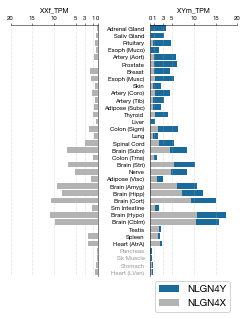

In [18]:
fig, axes = plot_expression_in_xx_vs_xy(df, 'NLGN4X/NLGN4Y')
axes[0].set_xlim(20, 0)
axes[1].set_xlim(0, 20)
for ax in axes:
    ax.set_xticks([0, 1, 3, 5, 10, 15, 20])

fig.savefig("{}/NLGN4XY_XX_vs_XY.pdf".format(outdir))

SOX3/SRY

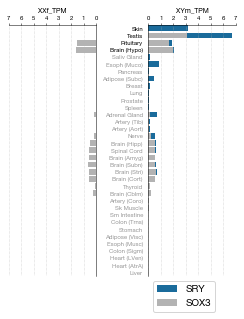

In [19]:
fig, axes = plot_expression_in_xx_vs_xy(df, 'SOX3/SRY')
axes[0].set_xlim(7, 0)
axes[1].set_xlim(0, 7)
for ax in axes:
    ax.set_xticks(np.arange(0, 8))

fig.savefig("{}/SOX3SRY_XX_vs_XY.pdf".format(outdir))

The above thresholds for calling a gene expressed in XY/not-expressed in XX were somewhat arbitrary, but the plot below shows that, in general, the MSY genes tend to show the same or lesser expression breadth than their X homologs. (**Figure 2—figure supplement 6**)

In [20]:
ytorder

NameError: name 'ytorder' is not defined

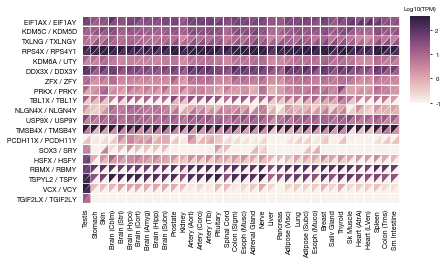

In [21]:
# order tissues in plot like MSY clustermap
t_order = ybt1.columns[clustmap.dendrogram_col.reordered_ind]

# order genes like in MSY clustermap (after rotation)
y_order = ['EIF1AY', 'KDM5D', 'TXLNGY', 'RPS4Y1', 
           'UTY', 'DDX3Y', 'ZFY', 'PRKY',
           'TBL1Y', 'NLGN4Y', 'USP9Y', 'TMSB4Y',
           'PCDH11Y', 'SRY', 'HSFY', 'RBMY', 
           'TSPY', 'VCY', 'TGIF2LY']
x_order = ['EIF1AX', 'KDM5C', 'TXLNG', 'RPS4X', 
           'KDM6A', 'DDX3X', 'ZFX', 'PRKX',
           'TBL1X', 'NLGN4X', 'USP9X', 'TMSB4X',
           'PCDH11X', 'SOX3', 'HSFX', 'RBMX', 
           'TSPYL2', 'VCX', 'TGIF2LX']

# get median expression levels by tissue for X and Y genes in males
xdata_m = mdata.loc[x_order]
xbt_m = general.stat_by_tissue(xdata_m, meta)

ydata_m = mdata.loc[y_order]
ybt_m = general.stat_by_tissue(ydata_m, meta)

vmax_log = 2.5  # trim log10(TPM) values beyond this value
vmin = 0.1      # trim TPM values lower than this value

xbt_m1 = xbt_m.copy()
xbt_m1[xbt_m1 < vmin] = vmin
ybt_m1 = ybt_m.copy()
ybt_m1[ybt_m1 < vmin] = vmin

xbt_m_ = np.log10(xbt_m1).reindex(t_order, axis=1)
ybt_m_ = np.log10(ybt_m1).reindex(t_order, axis=1)

fig, (ax, ax_cbar) = pf.heatmap_2d(xbt_m_, ybt_m_, palette=pf.COLPAL_SEQ, 
                                   vmax=vmax_log)

cticks = [-1, 0, 1, 2]
ax_cbar.set_yticks(cticks)
ax_cbar.set_yticklabels(cticks, size=6)
ax_cbar.set_title('Log10(TPM)', size=6)
ax_cbar.tick_params(axis='y', right=True, length=2)

ax.tick_params(left=False, bottom=False, pad=0)
ax = pf.simplify_tissues(ax, axis='x')
ax = pf.format_axis_labels(ax, ticklabsize=7)
fig.set_figwidth(7)

fig.savefig("{}/X_vs_Yhoms.XY_samps.med_by_tissue.2Dheatmap.pdf".format(outdir))